In [1]:
import numpy as np
from numpy.lib.recfunctions import append_fields
import matplotlib.pyplot as plt

import uproot
print("Using uproot: ", uproot.__version__)
import awkward as ak
print("Using awkward: ", ak.__version__)
import pyjet
print("Using pyjet: ",pyjet.__version__)
# When pyjet version older than 1.7.0 run pip install pyjet==1.7.0 

Using uproot:  4.0.1
Using awkward:  1.0.2
Using pyjet:  1.7.0


### Load jets from Jet_ and GenJet_
Can list all characteristics/ Branches of event via ```event_tree.keys(), event_tree.show() ```.
The variable idx defines the id of the considered event. All following code will examine that event only.

In [2]:
file = uproot.open("/eos/user/c/clange/PFNano/myNanoProdMc_NANO.root")
event_tree = file['Events']

In [16]:
idx = 1
# Usually array of arrays, one for each event. But since only one event considered here include [0].
# PF candidates
pts = event_tree['PF_pt'].array(entry_start=idx, entry_stop=idx+1, library='np')[0]
etas = event_tree['PF_eta'].array(entry_start=idx, entry_stop=idx+1, library='np')[0]
phis = event_tree['PF_phi'].array(entry_start=idx, entry_stop=idx+1, library='np')[0]
masses = event_tree['PF_mass'].array(entry_start=idx, entry_stop=idx+1, library='np')[0]
puppi_weights = event_tree['PF_puppiWeight'].array(entry_start=idx, entry_stop=idx+1, library='np')[0]

# reconstructed jets from simulation
recojet_pts = event_tree['Jet_pt'].array(entry_start=idx, entry_stop=idx+1, library='np')[0]
recojet_etas = event_tree['Jet_eta'].array(entry_start=idx, entry_stop=idx+1, library='np')[0]
recojet_phis = event_tree['Jet_phi'].array(entry_start=idx, entry_stop=idx+1, library='np')[0]
recojet_masses = event_tree['Jet_mass'].array(entry_start=idx, entry_stop=idx+1, library='np')[0]
recojet_nconstituents = event_tree['Jet_nConstituents'].array(entry_start=idx, entry_stop=idx+1, library='np')[0]
raw_pt_factor = 1-event_tree['Jet_rawFactor'].array(entry_start=idx, entry_stop=idx+1, library='np')[0] # apply factor to recojet_pts and recojet masses to get values before missing energy correction

# simulation source
genjet_pts = event_tree['GenJet_pt'].array(entry_start=idx, entry_stop=idx+1, library='np')[0]
genjet_etas = event_tree['GenJet_eta'].array(entry_start=idx, entry_stop=idx+1, library='np')[0]
genjet_phis = event_tree['GenJet_phi'].array(entry_start=idx, entry_stop=idx+1, library='np')[0]
genjet_masses = event_tree['GenJet_mass'].array(entry_start=idx, entry_stop=idx+1, library='np')[0]

### cluster jets manually
Using anti-kt with $R=0.4$ and the conventional $p_T=15$ GeV cut off. Further, use data (```PF_puppiWeight```) from event_tree, indicating  whether a particle is part of the pileup (value close to 0) or part of the signal (value close 1), to give signal particles a larger weight in the clustering.   

In [17]:
# make array of 4 vector
event_4vect = np.column_stack((pts*puppi_weights , etas, phis, masses)).astype('float64')

# convert to structured array and add id of PF candidate
event = np.core.records.fromarrays(event_4vect.transpose(), dtype=pyjet.DTYPE_PTEPM)
event = append_fields(event, 'id', data=np.arange(len(event))).data

# only consider particles with non zero weight
event_mask = np.where(puppi_weights!=0, True, False)
event = event[event_mask]

# cluster; jets will be a list of PseudoJet objects
sequence = pyjet.cluster(event, R=0.4, p=-1)
my_jets = sequence.inclusive_jets(ptmin=15)

print(f"# of jets: {len(my_jets)}")
print(f"# of unclustered particles: {len(sequence.unclustered_particles())}")

# of jets: 4
# of unclustered particles: 0


### Comparison
Compare my jets with recojets(multiplied by raw pt factor) and genjets. Note that to get a correct comparison, one would need to employ a matching algorithm to pair the most similar jets.

In [18]:
recojet_rawpts = recojet_pts*raw_pt_factor
recojet_rawmasses = recojet_masses*raw_pt_factor

print("Event: {}\n--------".format(idx))
#print("Number of jets:\nmy jets:\t{}\nreco jets:\t{}\ngen jets:\t{}\n\nEvent: {}--------".format(len(my_jets), len(recojet_pts), len(genjet_pts), idx))

#maxi = max(len(my_jets), len(recojet_pts), len(genjet_pts))
print("{0: <10} {1: >9} {2: >10} {3: >10} {4: >10} {5: >10}".format(
    "source", "pT", "eta", "phi", "mass", "#constit."))
maxi = max(len(my_jets), len(recojet_pts))
for i in range(maxi):
    #print("Considering jet {}".format(i))
    print("Jet id: {}".format(i))


    if i < len(my_jets):
        print("{0: <10} {1: 10.3f} {2: 10.3f} {3: 10.3f} {4: 10.3f} {5: 10}".format(
                'my jet', my_jets[i].pt, my_jets[i].eta, my_jets[i].phi, my_jets[i].mass, len(my_jets[i].constituents())))
    if i < len(recojet_pts):
        print("{0: <10} {1: 10.3f} {2: 10.3f} {3: 10.3f} {4: 10.3f} {5: 10}".format(
                'reco jet', recojet_rawpts[i], recojet_etas[i], recojet_phis[i], recojet_rawmasses[i], recojet_nconstituents[i]))
#     if i < len(genjet_pts):
#         print("{0: <10} {1: 10.3f} {2: 10.3f} {3: 10.3f} {4: 10.3f} {5: >10}".format(
#                 'gen jet', genjet_pts[i], genjet_etas[i], genjet_phis[i], genjet_masses[i], "NAN"))
    #print("--------\n")

Event: 1
--------
source            pT        eta        phi       mass  #constit.
Jet id: 0
my jet         19.253      0.013     -2.838      4.977         18
reco jet       19.752      1.857     -1.764      4.428         14
Jet id: 1
my jet         18.777      1.856     -1.755      4.049         13
reco jet       21.070      0.022     -2.836      5.503         19
Jet id: 2
my jet         16.725      0.743      1.312      2.946         10
reco jet       17.296      2.321     -1.532      3.528         11
Jet id: 3
my jet         15.847      2.299     -1.521      2.777          8
reco jet       17.078      0.741      1.308      3.020         11
Jet id: 4
reco jet       15.442      0.744     -3.086      4.251         12


# Event display for single event showing my analysis results and comparing with simulated jets

In [13]:
from matplotlib.pyplot import cm
from matplotlib.colors import LinearSegmentedColormap

In [19]:
# define eta and phi ranges and number of bins along each axis
eta_min, eta_max = -5., 5.
extent = eta_min, eta_max, -np.pi, np.pi
bins = 100 # decrease to increase pixel size in plot

# create regular grid of ghosts
eta_edges = np.linspace(eta_min, eta_max, bins + 1)
phi_edges = np.linspace(-np.pi, np.pi, bins + 1)
eta = np.linspace(eta_min, eta_max, bins + 1)[:-1] + (eta_max - eta_min) / (2 * bins)
phi = np.linspace(-np.pi, np.pi, bins + 1)[:-1] + (np.pi / bins)
X, Y = np.meshgrid(eta, phi)
ghosts = np.zeros(eta.shape[0] * phi.shape[0], dtype=pyjet.DTYPE_PTEPM) # datatype is pt, eta, phi, mass
ghosts['pT'] = 1e-8
ghosts['eta'] = X.ravel() # Returns a contiguous flattened array. See np documentation
ghosts['phi'] = Y.ravel()

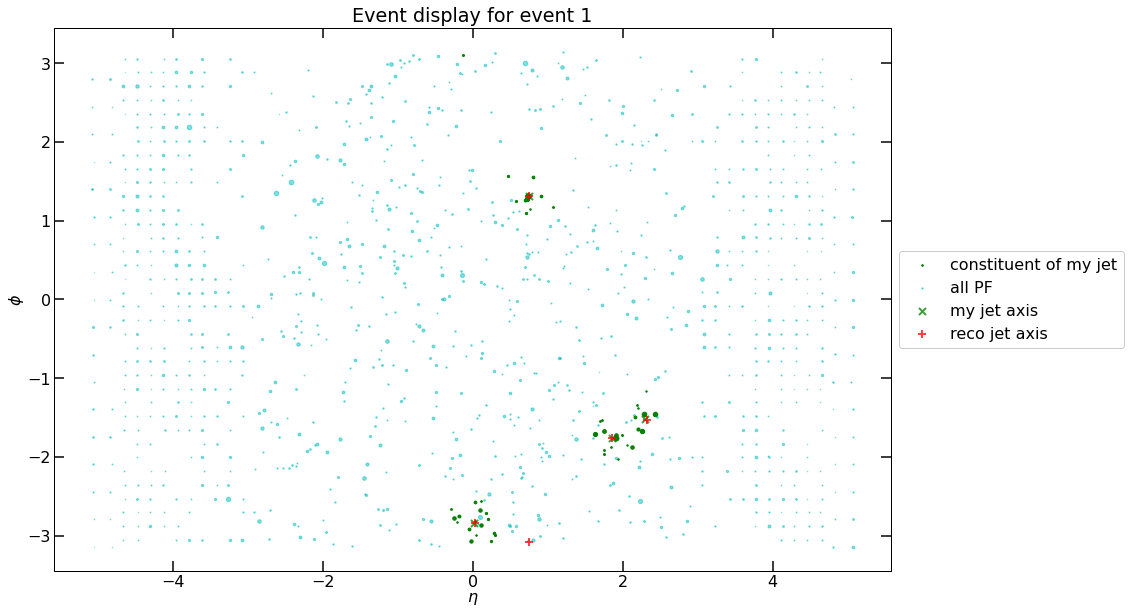

In [20]:
plt.style.use('scientific.mplstyle')
plt.rcParams["figure.figsize"] = (15,10)
fig = plt.figure()
ax = plt.gca()

# plot al PF candidates, costituents of my jet and the jet axis of my jets and recojets
PF_idx_in_myjets = []
for myjet in my_jets:
    for consti in myjet:
        PF_idx_in_myjets.append(consti.id)
        
        
# plot PF as circles with size as fraction of largest measured pt
max_pt = max(pts)
for PF_idx in range(len(pts)):
    if PF_idx in PF_idx_in_myjets:
        color_choice = 'green'
        alpha = 1
    else:
        color_choice = 'c'
        alpha = 0.5
        idx_not_in_myjet = PF_idx
        
    ax.scatter(etas[PF_idx], phis[PF_idx], c=color_choice, s=30*pts[PF_idx]/max_pt, alpha=alpha)
    
# repeat plotting of one particle (in my jets and not in my jets) to add label
ax.scatter(etas[PF_idx_in_myjets[0]], phis[PF_idx_in_myjets[0]], c="green", s=30*pts[PF_idx_in_myjets[0]]/max_pt, alpha=1, label='constituent of my jet')
ax.scatter(etas[idx_not_in_myjet], phis[idx_not_in_myjet], c="c", s=30*pts[idx_not_in_myjet]/max_pt, alpha=0.5, label='all PF')
        
# plot jet axis
myjet_etas, myjet_phis = [myjet.eta for myjet in my_jets], [myjet.phi for myjet in my_jets]
ax.scatter(myjet_etas, myjet_phis, marker='x', c="green", s=50, alpha=0.75, label='my jet axis')    
ax.scatter(recojet_etas, recojet_phis, marker='+', c="red", s=50, alpha=0.75, label='reco jet axis')


title = f"Event display for event {idx}"
plt.title(title)
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)

plt.show()

img_title = f"plots/event_displays_{idx}.pdf"
#fig.savefig(img_title, bbox_extra_artists=(lgd,), bbox_inches='tight')